In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive
import time

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Normal Discrete Fourier Transform (DFT)

In [ ]:
def DFT(y):
  """
  Compute the Discrete Fourier Transform of the 1D signal y
  This function has the worst-case time complexiy of O(N^2)
  due to the nested loop along the row and column to compute
  the entry for the square matrix M.
  """
  N = len(y)

  # Create a matrix of size N by N
  M = np.zeros((N,N), dtype=complex)

  # Fundamental frequency
  w = np.exp(-2j*np.pi/N)
  for i in range(N):
    for j in range(N):
      M[i][j] = w**(i*j)

  # Performs the matrix multiplication M * y
  return np.matmul(M, y)

def IDFT(Y):
  """
  Compute the Inverse Discrete Fourier Transform of the 1D signal Y
  This function has the worst-case time complexiy of O(N^2)
  due to the nested loop along the row and column to compute
  the entry for the square matrix M.
  """
  N = len(Y)
  M = np.zeros((N,N), dtype=complex)

  # Positive exponent for inverse
  w = np.exp(2j*np.pi/N)
  for i in range(N):
    for j in range(N):
       M[i][j] = w**(i*j)

  # Division by N
  return np.matmul(M, Y) / N

In [ ]:
def DFT_2D(image):
  """
  Compute the 2D DFT of an image.
  This function has the time complexity of O(N) because
  it computes the DFT along each dimension separately.
  """
  height, width = image.shape
  result = np.zeros((height, width), dtype=complex)

  # Apply 1D DFT to each row
  for i in range(height):
    result[i, :] = DFT(image[i, :])

  # Apply 1D DFT to each column
  for j in range(width):
    result[:, j] = DFT(result[:, j])

  return result

def IDFT_2D(freq_domain):
  """
  Compute the 2D inverse DFT of a frequency domain representation
  This function has the time complexity of O(N) because
  it computes the DFT along each dimension separately.
  """
  height, width = freq_domain.shape
  result = np.zeros((height, width), dtype=complex)

  # Apply 1D IDFT to each column
  for j in range(width):
    result[:, j] = IDFT(freq_domain[:, j])

  # Apply 1D IDFT to each row
  for i in range(height):
    result[i, :] = IDFT(result[i, :])

  return result

In [ ]:
def shift_zero_freq_to_center(freq_domain):
  """
  Shift the zero-frequency component to the center of the spectrum
  Low frequencies appear near the center, and high frequencies appear near the edges.
  """
  height, width = freq_domain.shape
  shifted = np.zeros_like(freq_domain)

  for i in range(height):
    for j in range(width):
      shifted[(i + height//2) % height, (j + width//2) % width] = freq_domain[i, j]

  return shifted

def compress_image_with_dft(image_path, compression_ratio, size=None):
  """
  Compress an image using DFT and thresholding

  Parameters:
  - image_path: Path to the image file
  - compression_ratio: Fraction of coefficients to keep (0 to 1)
  - size: Optional tuple (width, height) to resize the image

  Returns:
  - original: Original image
  - compressed: Compressed image
  - spectrum: Magnitude spectrum (for visualization)
  - compressed_spectrum: Compressed spectrum (for visualization)
  """

  start_time = time.time()

  # Load and convert image to grayscale
  img = Image.open(image_path).convert('L')
  if size:
    img = img.resize(size)

  # Convert to numpy array
  img_array = np.array(img, dtype=float)

  # Compute 2D DFT
  dft = DFT_2D(img_array)

  # Shift zero frequency to center for better visualization
  dft_shifted = shift_zero_freq_to_center(dft)

  # Calculate magnitude spectrum (for visualization)
  magnitude_spectrum = np.log(np.abs(dft_shifted) + 1)

  # Compression: Keep only the largest coefficients
  dft_abs = np.abs(dft_shifted)
  threshold_idx = int(dft_abs.size * (1 - compression_ratio))
  threshold = np.sort(dft_abs.flatten())[threshold_idx]

  # Create mask based on threshold
  mask = dft_abs >= threshold
  dft_compressed = dft_shifted * mask

  # Shift back before inverse transform
  dft_compressed = shift_zero_freq_to_center(dft_compressed)

  # Compute inverse DFT
  img_compressed = IDFT_2D(dft_compressed)

  # Extract real part and normalize
  img_compressed = np.real(img_compressed)
  img_compressed = np.clip(img_compressed, 0, 255).astype(np.uint8)

  end_time = time.time()  # Record end time
  compression_time = end_time - start_time

  print(f"Compression time: {compression_time:.4f} seconds")

  return img_array, img_compressed, magnitude_spectrum, np.abs(dft_compressed)

def display_results_compressed(original, compressed_images, compression_ratios):
  """
  Display the original and compressed images.
  """
  num_images = len(compressed_images) + 1

  fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))

  # Display original image
  axes[0].imshow(original, cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  # Display compressed images
  for i, (compressed, ratio) in enumerate(zip(compressed_images, compression_ratios)):
    axes[i + 1].imshow(compressed, cmap='gray')
    axes[i + 1].set_title(f'Compressed (Ratio: {ratio})')
    axes[i + 1].axis('off')

  plt.tight_layout()
  plt.show()

In [ ]:
def visualize_compressed_ratios(image_path: str, compression_ratios: list, size=None):
  # Load and process the original image
  original, _, _, _ = compress_image_with_dft(image_path, 0.1, size=size)

  # Compress the image with different ratios and store the results
  compressed_images = []
  for ratio in compression_ratios:
    _, compressed, _, _ = compress_image_with_dft(image_path, ratio, size=size)
    compressed_images.append(compressed)

  display_results_compressed(original, compressed_images, compression_ratios)

### Results

Compression time: 94.9532 seconds
Compression time: 91.3128 seconds
Compression time: 94.2334 seconds
Compression time: 94.1631 seconds
Compression time: 92.1656 seconds


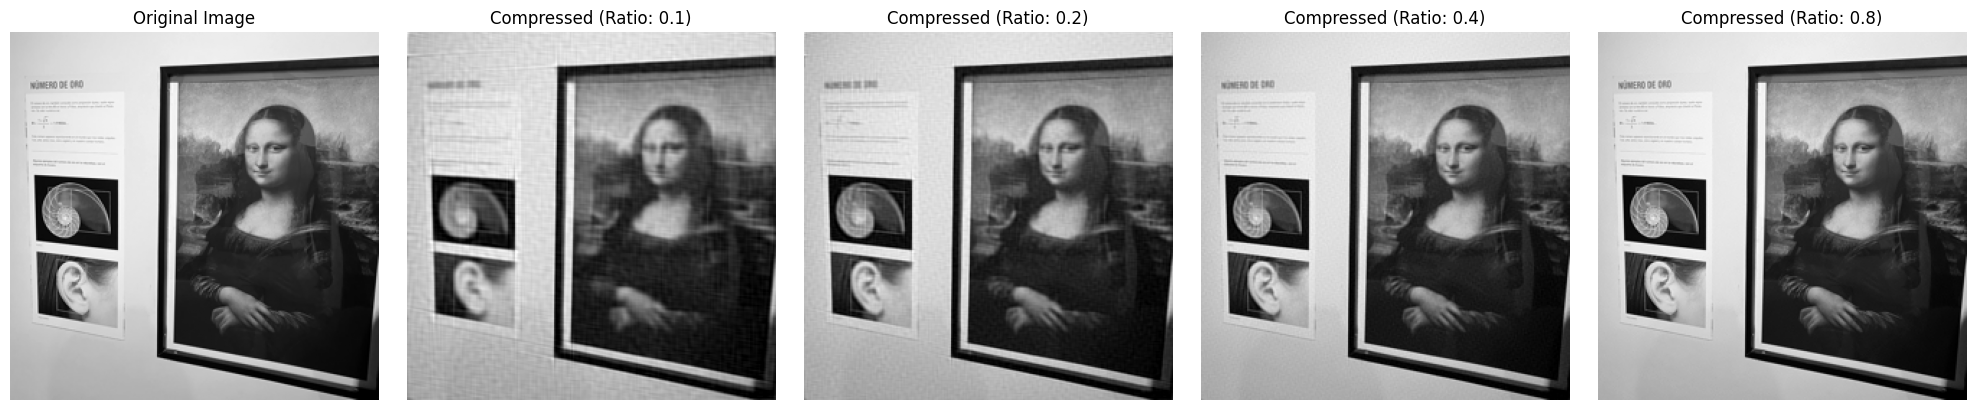

In [ ]:
visualize_compressed_ratios('/content/drive/MyDrive/24-25 Academic Year/CS154 - Differential Equations/Image Compression/science_museum.jpeg', compression_ratios=[0.1, 0.2, 0.4, 0.8], size=(256, 256))

Compression time: 90.8533 seconds
Compression time: 89.4801 seconds
Compression time: 92.3983 seconds
Compression time: 89.3766 seconds
Compression time: 97.4390 seconds


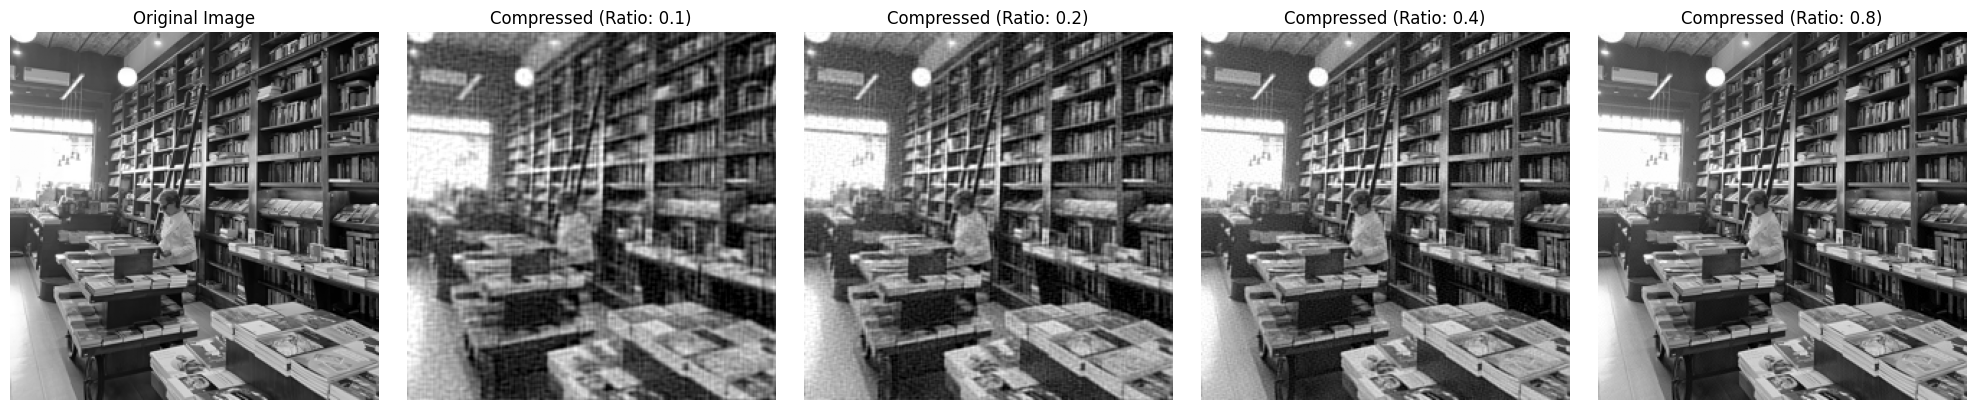

In [ ]:
visualize_compressed_ratios('/content/drive/MyDrive/24-25 Academic Year/CS154 - Differential Equations/Image Compression/palermo.jpeg', compression_ratios=[0.1, 0.2, 0.4, 0.8], size=(256, 256))

### Time Complexity

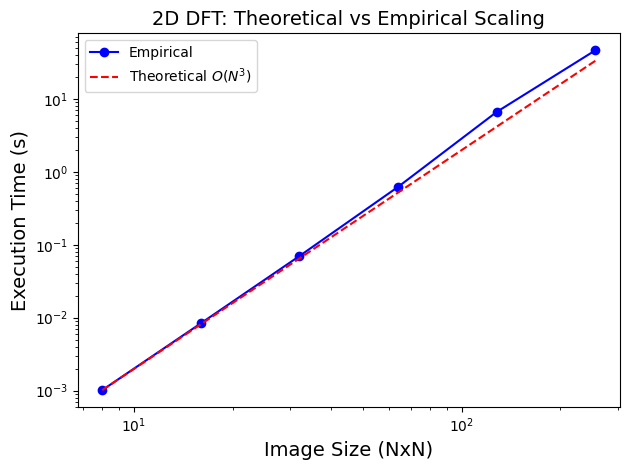

In [ ]:
# Test with different sizes
sizes = [8, 16, 32, 64, 128, 256]
times = []

for size in sizes:
  img = np.random.random((size, size))
  start = time.time()
  _ = DFT_2D(img)
  end = time.time()
  times.append(end - start)

# Calculate theoretical O(N^3) times
sizes_array = np.array(sizes)
times_array = np.array(times)
coefficient = times_array[0] / (sizes_array[0]**3)
theoretical_times = coefficient * sizes_array**3

# Plot results
plt.figure()
plt.loglog(sizes_array, times_array, 'bo-', label='Empirical')
plt.loglog(sizes_array, theoretical_times, 'r--', label=f'Theoretical $O(N^3)$')
plt.xlabel('Image Size (NxN)', fontsize=14)
plt.ylabel('Execution Time (s)', fontsize=14)
plt.title('2D DFT: Theoretical vs Empirical Scaling', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# Fast Fourier Transform (FFT)

In [ ]:
def fft_1d(x):
  """
  1D FFT implementation using the Cooley-Tukey algorithm.
  Input:
    x: 1D numpy array
  Returns:
    1D numpy array of same length with FFT result
  """
  N = len(x)

  # Base case for recursion
  if N == 1:
      return x

  # Ensure N is a power of 2
  if N & (N-1) != 0:
      raise ValueError("Size must be a power of 2")

  # Split into even and odd indices
  even = fft_1d(x[0::2])
  odd = fft_1d(x[1::2])

  # Combine using butterfly operations
  # This basically means breaking down a large DFT into smaller, more manageable DFTs.
  factor = np.exp(-2j * np.pi * np.arange(N) / N)

  # First half of result
  first_half = even + factor[:N//2] * odd

  # Second half of result
  second_half = even + factor[N//2:] * odd

  return np.concatenate([first_half, second_half])

def ifft_1d(x):
  """
  1D Inverse FFT implementation.
  """
  N = len(x)

  # Conjugate input
  x_conj = np.conjugate(x)

  # Perform FFT on conjugated input
  result = fft_1d(x_conj)

  # Conjugate result and scale by 1/N
  return np.conjugate(result) / N

def fft_2d(image):
  """
  2D FFT implementation.
  Input:
    image: 2D numpy array
  Returns:
    2D numpy array of same shape with FFT result
  """
  height, width = image.shape

  # Ensure both dimensions are powers of 2
  if (height & (height-1) != 0) or (width & (width-1) != 0):
      raise ValueError("Both dimensions must be powers of 2")

  # Apply 1D FFT to each row
  result = np.zeros(image.shape, dtype=complex)
  for i in range(height):
    result[i, :] = fft_1d(image[i, :])

  # Apply 1D FFT to each column
  for j in range(width):
    result[:, j] = fft_1d(result[:, j])

  return result

def ifft_2d(freq_domain):
  """
  Custom 2D Inverse FFT implementation.
  """
  height, width = freq_domain.shape

  # Apply 1D IFFT to each column
  result = np.zeros(freq_domain.shape, dtype=complex)
  for j in range(width):
    result[:, j] = ifft_1d(freq_domain[:, j])

  # Apply 1D IFFT to each row
  for i in range(height):
    result[i, :] = ifft_1d(result[i, :])

  return result

def fftshift_2d(x):
  """
  Implementation of fftshift to move zero-frequency component to center.
  This operation has a time complexity of O(N^2) because of the nested loop
  that shift the zero freq to the center
  """
  height, width = x.shape
  shifted = np.zeros_like(x)

  for i in range(height):
    for j in range(width):
      shifted[(i + height//2) % height, (j + width//2) % width] = x[i, j]

  return shifted

def ifftshift_2d(x):
  """
  Implementation of ifftshift (inverse of fftshift).
  Since fftshift is its own inverse for even-sized arrays, this is identical.
  """
  return fftshift_2d(x)

def measure_fft_performance(sizes):
  """
  Measure the performance of our custom FFT implementation.
  """
  times = []

  for size in sizes:
    # Create random test image (power of 2 sizes)
    img_array = np.random.random((size, size))

    # Measure time for FFT operations
    start = time.time()

    # Main FFT operations
    fft_result = fft_2d(img_array)
    fft_shifted = fftshift_2d(fft_result)
    fft_compressed_unshifted = ifftshift_2d(fft_shifted)
    img_compressed = ifft_2d(fft_compressed_unshifted)

    end = time.time()
    times.append(end - start)

  return np.array(times)

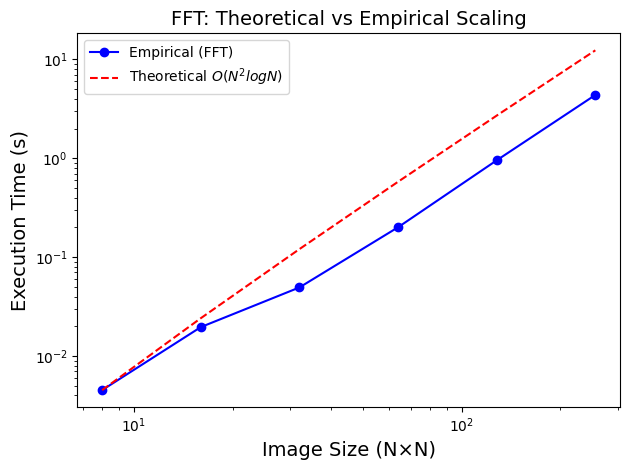

In [ ]:
# Test with power-of-2 image sizes
sizes = np.array([8, 16, 32, 64, 128, 256])
times = measure_fft_performance(sizes)

# Calculate theoretical O(N^2 log N) times
coefficient = times[0] / (sizes[0]**2 * np.log2(sizes[0]))
theoretical_times = coefficient * sizes**2 * np.log2(sizes)

# Plot results
plt.figure()
plt.loglog(sizes, times, 'bo-', label='Empirical (FFT)')
plt.loglog(sizes, theoretical_times, 'r--', label=f'Theoretical $O(N^2 log N)$')
plt.xlabel('Image Size (N×N)', fontsize=14)
plt.ylabel('Execution Time (s)', fontsize=14)
plt.title('FFT: Theoretical vs Empirical Scaling', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def compress_image_with_fft(image_path, compression_ratio, size=None):
  """Compress an image using FFT and thresholding."""
  start_time = time.time()

  img = Image.open(image_path).convert('L')
  if size:
      img = img.resize(size)

  # Find nearest power of 2 dimensions
  width, height = img.size
  new_width = 2**int(np.log2(width))
  new_height = 2**int(np.log2(height))

  # Adjust if needed
  if new_width < width: new_width *= 2
  if new_height < height: new_height *= 2

  img = img.resize((new_width, new_height))
  img_array = np.array(img, dtype=float)

  # Apply FFT
  fft_result = fft_2d(img_array)
  fft_shifted = fftshift_2d(fft_result)

  # Compression: keep only largest coefficients
  fft_abs = np.abs(fft_shifted)
  threshold_idx = int(fft_abs.size * (1 - compression_ratio))
  threshold = np.sort(fft_abs.flatten())[threshold_idx]

  mask = fft_abs >= threshold
  fft_compressed = fft_shifted * mask

  # Inverse operations
  fft_compressed_unshifted = fftshift_2d(fft_compressed)
  img_compressed = ifft_2d(fft_compressed_unshifted)

  # Process result
  img_compressed = np.real(img_compressed)
  img_compressed = np.clip(img_compressed, 0, 255).astype(np.uint8)

  end_time = time.time()  # Record end time
  compression_time = end_time - start_time

  print(f"Compression time: {compression_time:.4f} seconds")

  return img_array, img_compressed

def visualize_compressed_ratios(image_path, compression_ratios, size=None):
  """Visualize an image compressed with different ratios."""
  # Get original image
  original, _ = compress_image_with_fft(image_path, 1.0, size=size)

  # Compress with different ratios
  compressed_images = []
  for ratio in compression_ratios:
      _, compressed = compress_image_with_fft(image_path, ratio, size=size)
      compressed_images.append(compressed)

  # Display results
  num_images = len(compressed_images) + 1
  fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))

  axes[0].imshow(original, cmap='gray')
  axes[0].set_title('Original')
  axes[0].axis('off')

  for i, (compressed, ratio) in enumerate(zip(compressed_images, compression_ratios)):
    axes[i+1].imshow(compressed, cmap='gray')
    axes[i+1].set_title(f'Ratio: {ratio}')
    axes[i+1].axis('off')

  plt.tight_layout()
  plt.show()

Compression time: 15.2893 seconds
Compression time: 14.4359 seconds
Compression time: 12.7311 seconds
Compression time: 13.2575 seconds
Compression time: 15.1130 seconds


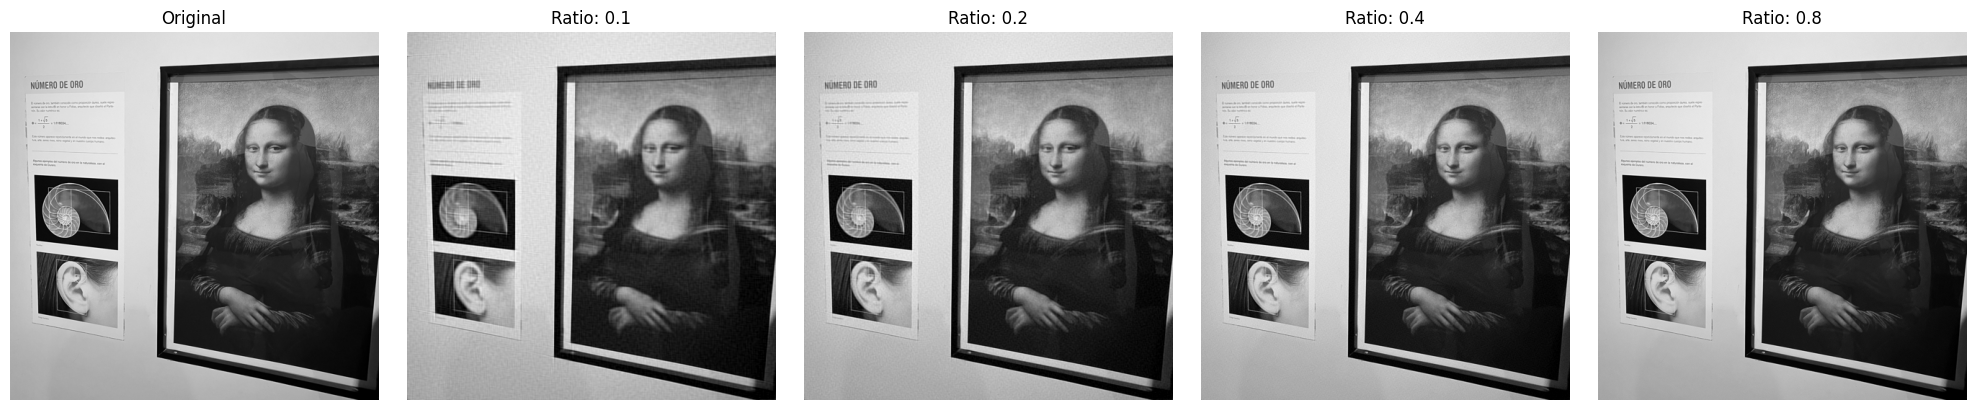

In [ ]:
visualize_compressed_ratios('/content/drive/MyDrive/24-25 Academic Year/CS154 - Differential Equations/Image Compression/science_museum.jpeg', [0.1, 0.2, 0.4, 0.8], size=(512, 512))

Compression time: 12.9337 seconds
Compression time: 12.5579 seconds
Compression time: 12.7817 seconds
Compression time: 12.8033 seconds
Compression time: 12.7690 seconds


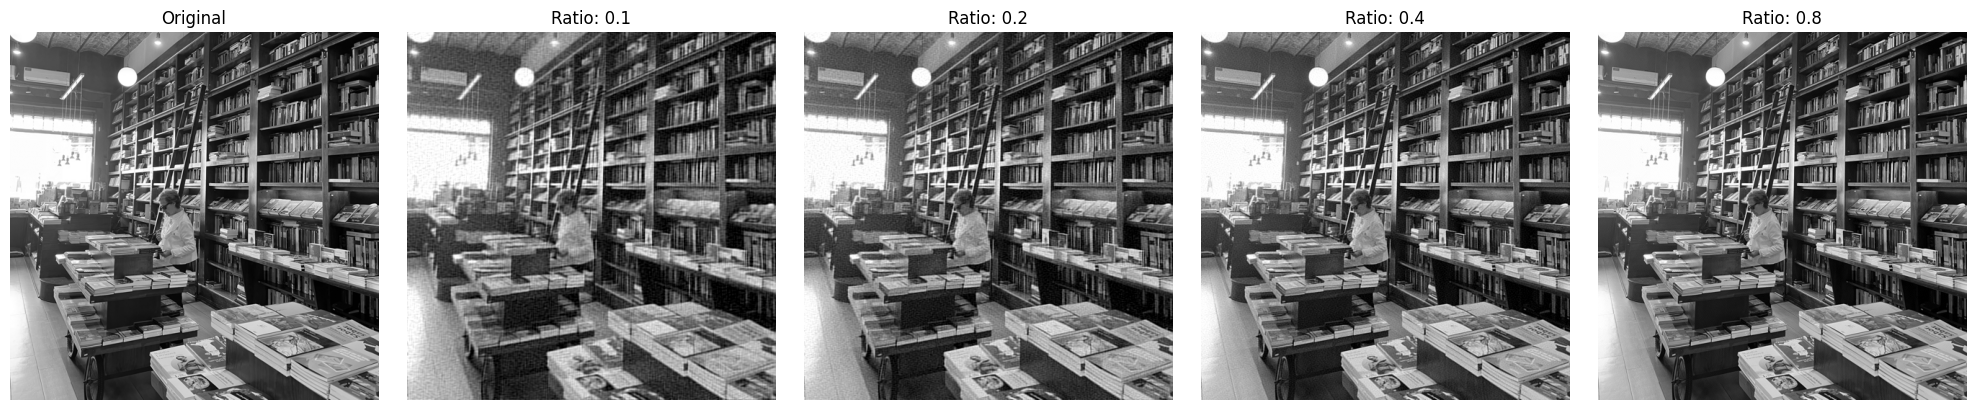

In [ ]:
visualize_compressed_ratios('/content/drive/MyDrive/24-25 Academic Year/CS154 - Differential Equations/Image Compression/palermo.jpeg', [0.1, 0.2, 0.4, 0.8], size=(512, 512))

In [ ]:
from scipy.fft import fft2, ifft2, fftshift, ifftshift

def compress_image_fft(image_path, compression_ratio):
    """
    Compress an image using FFT with built-in methods

    Parameters:
    - image_path: Path to the image file
    - compression_ratio: Fraction of coefficients to keep (0 to 1)
    - display: Whether to display results

    Returns:
    - original: Original image
    - compressed: Compressed image
    """
    # Load and convert image to grayscale
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)

    # Step 1: Apply FFT
    fft_result = fft2(img_array)

    # Step 2: Shift zero-frequency component to center
    fft_shifted = fftshift(fft_result)

    # Step 3: Calculate magnitude for visualization
    magnitude_spectrum = np.log(np.abs(fft_shifted) + 1)

    # Step 4: Compression - keep only the largest coefficients
    fft_abs = np.abs(fft_shifted)
    threshold_idx = int(fft_abs.size * (1 - compression_ratio))
    threshold = np.sort(fft_abs.flatten())[threshold_idx]

    # Create mask based on threshold
    mask = fft_abs >= threshold
    fft_compressed = fft_shifted * mask

    # Step 5: Inverse shift and inverse FFT
    fft_compressed_unshifted = ifftshift(fft_compressed)
    img_compressed = ifft2(fft_compressed_unshifted)

    # Step 6: Convert back to real image
    img_compressed = np.real(img_compressed)
    img_compressed = np.clip(img_compressed, 0, 255).astype(np.uint8)

    # Calculate metrics
    kept_coeffs = np.count_nonzero(mask)
    total_coeffs = mask.size
    compression_achieved = total_coeffs / kept_coeffs if kept_coeffs > 0 else float('inf')

    return img_array, img_compressed

def display_results_compressed(original, compressed_images, compression_ratios):
  num_images = len(compressed_images) + 1

  fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))

  # Display original image
  axes[0].imshow(original, cmap='gray')
  axes[0].set_title('Original Image')
  axes[0].axis('off')

  # Display compressed images
  for i, (compressed, ratio) in enumerate(zip(compressed_images, compression_ratios)):
      axes[i + 1].imshow(compressed, cmap='gray')
      axes[i + 1].set_title(f'Compressed (Ratio: {ratio})')
      axes[i + 1].axis('off')

  plt.tight_layout()
  plt.show()

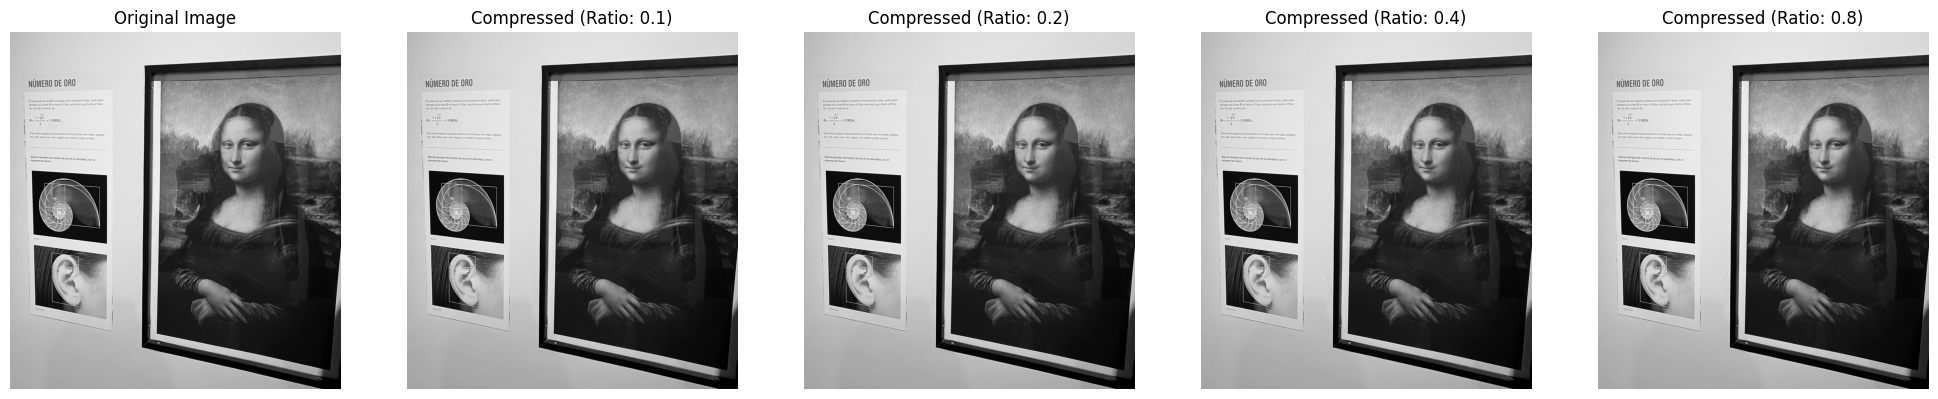

In [ ]:
compression_ratios = [0.1, 0.2, 0.4, 0.8]
original, _ = compress_image_fft('/content/drive/MyDrive/24-25 Academic Year/CS154 - Differential Equations/Image Compression/science_museum.jpeg', 0.05)
compressed_images = []
for ratio in compression_ratios:
    _, compressed = compress_image_fft('/content/drive/MyDrive/24-25 Academic Year/CS154 - Differential Equations/Image Compression/science_museum.jpeg', ratio)
    compressed_images.append(compressed)

display_results_compressed(original, compressed_images, compression_ratios)

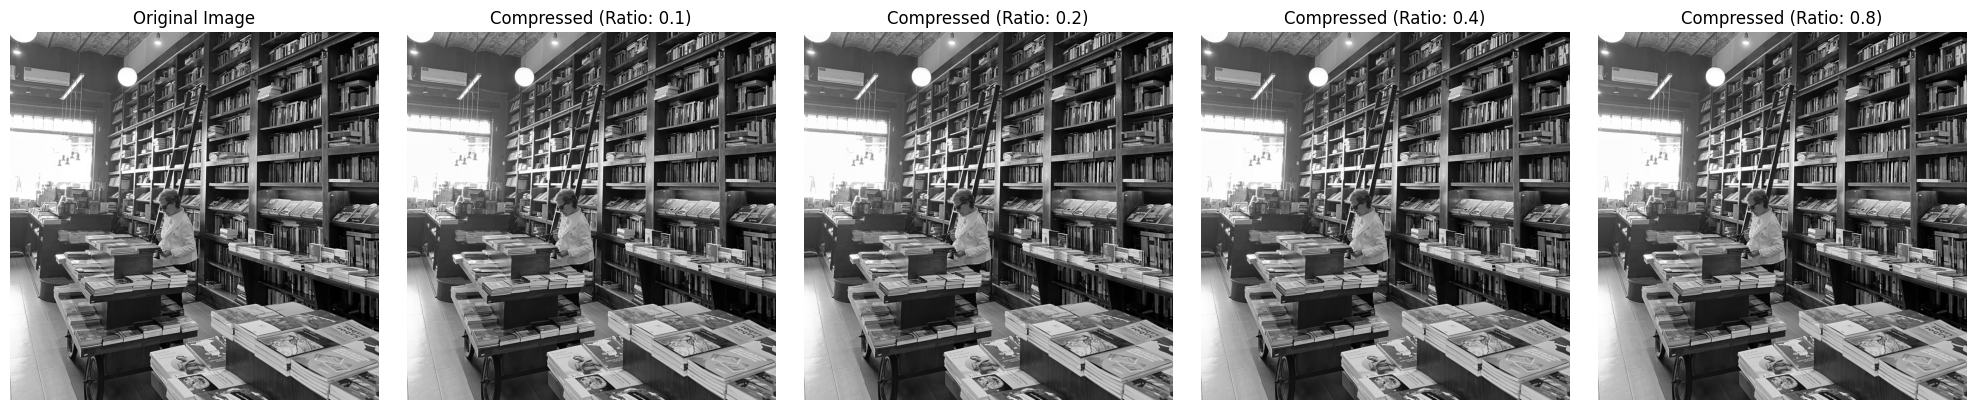

In [ ]:
compression_ratios = [0.1, 0.2, 0.4, 0.8]
original, _ = compress_image_fft('/content/drive/MyDrive/24-25 Academic Year/CS154 - Differential Equations/Image Compression/palermo.jpeg', 0.05)
compressed_images = []
for ratio in compression_ratios:
    _, compressed = compress_image_fft('/content/drive/MyDrive/24-25 Academic Year/CS154 - Differential Equations/Image Compression/palermo.jpeg', ratio)
    compressed_images.append(compressed)

display_results_compressed(original, compressed_images, compression_ratios)